# Neural Network
This notebook will demonstrate an implementation of an artificial neural network (multi-layer perceptron) with the [IBMEmployeeAttrition](https://github.com/Madison-Bunting/INDE-577/blob/main/IBMEmployeeAttrition.csv) dataset.

In [150]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV
from tensorflow import keras

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice end formatting
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

#ANN and DL libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

import random as rn

#importing the dataset as a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/Madison-Bunting/INDE-577/main/IBMEmployeeAttrition.csv")

## Pre-Processing
Before we can create a multi-layer perceptron with this dataset, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

First, remove variables with zero variance (as uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook.

In [151]:
#Drop variables with zero variance: EmployeeCount, Over18, and StandardHours
df.drop(['BusinessTravel','DailyRate',
         'EmployeeCount','EmployeeNumber',
         'HourlyRate','MonthlyRate',
         'NumCompaniesWorked','Over18',
         'StandardHours', 'StockOptionLevel',
         'TrainingTimesLastYear'],
        axis=1,inplace=True)

In [152]:
def transform(feature):
    le=preprocessing.LabelEncoder()
    df[feature]=le.fit_transform(df[feature])
    print(le.classes_)

In [153]:
#Pull out the categorical variables
cat_df=df.select_dtypes(include='object')
cat_df.columns

#encode the categorical columns
for col in cat_df.columns:
    transform(col)

['No' 'Yes']
['Human Resources' 'Research & Development' 'Sales']
['Human Resources' 'Life Sciences' 'Marketing' 'Medical' 'Other'
 'Technical Degree']
['Female' 'Male']
['Healthcare Representative' 'Human Resources' 'Laboratory Technician'
 'Manager' 'Manufacturing Director' 'Research Director'
 'Research Scientist' 'Sales Executive' 'Sales Representative']
['Divorced' 'Married' 'Single']
['No' 'Yes']


In [154]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(df.drop('Attrition',axis=1))
y = df['Attrition'].to_numpy()
y = to_categorical(y)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To create a neural network, we will split the dataset into "training" and "test" data.

In [155]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)

As uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb), the dataset is imbalanced, with the ratio of those who left (attrition) to those who stayed being 1:6. Therefore we need to increase the number of observations corresponding to the minority class, which is called **oversampling**.

In the cell below, we use SMOTE (Synthetic Minority Oversampling Technique), which randomly creates "synthetic" instances of the minority class (yes) so the net observations in both classes are balanced. 

In [156]:
#x_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)

In [157]:
#seeding to get reproducible results
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Building the model
Below, we create a linear stack of layers, then add layers, specifying the number of units (neurons) and the activation function. 

- relu: for hidden layers
- sigmoid: for output layers

Only the first layer expects the input dimensions, so it knows the shape of the input numpy array.
The number of neurons in the final layer is equal to the number of classes in the target varaible; each neuron represents a specific target class, so the output of each neuron in the final layer represents the probability of a given observation being classified to that target class.

In [158]:
#Keras sequential model is a linear stack of layers
model=Sequential()
#Adding layers to the sequential model. For each layer, specify the number of units (neurons) and their activation function
model.add(Dense(input_dim=24,units=8,activation='relu'))
model.add(Dense(units=16,activation='relu'))
model.add(Dense(units=2,activation='sigmoid'))

Below, we compile the model using the Adam optimizer. Next, we specified "binary_crossentropy" as the loss function because this is a binary classification problem. Then, we specify accuracy as the metric to evaluate the model's performance.

In [159]:
model.compile(optimizer = Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

The information below provides an overall description of the model

In [160]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 200       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 34        
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________


Finally, we can fit the model to the training data, as with other machine learning algorithms. We specify the training and testing sets, as well as the number of epochs (an epoch is one full cycle of "forward and backward propagation" through all the training examples). Verbose is an optional parameter that ensures how the output of each epoch is displayed.

In [161]:
History = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, verbose = 1)

Epoch 1/10
35/35 [==============================] - 1s 9ms/step - loss: 0.5009 - accuracy: 0.7995 - val_loss: 0.3731 - val_accuracy: 0.8696
Epoch 2/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3990 - accuracy: 0.8312 - val_loss: 0.3526 - val_accuracy: 0.8750
Epoch 3/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3586 - accuracy: 0.8448 - val_loss: 0.3488 - val_accuracy: 0.8587
Epoch 4/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3368 - accuracy: 0.8603 - val_loss: 0.3433 - val_accuracy: 0.8750
Epoch 5/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3230 - accuracy: 0.8593 - val_loss: 0.3454 - val_accuracy: 0.8777
Epoch 6/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3148 - accuracy: 0.8702 - val_loss: 0.3428 - val_accuracy: 0.8668
Epoch 7/10
35/35 [==============================] - 0s 4ms/step - loss: 0.3050 - accuracy: 0.8684 - val_loss: 0.3591 - val_accuracy: 0.8804
Epoch 8/10
35/35 [==

In [162]:
y_pred = model.predict(X_test) 
classes = np.argmax(predict_x,axis=1)

# Performance Analysis
The next step is to conduct a performance analysis of the model. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve.

In [163]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.3665 - accuracy: 0.8723


[0.3664871156215668, 0.8722826242446899]

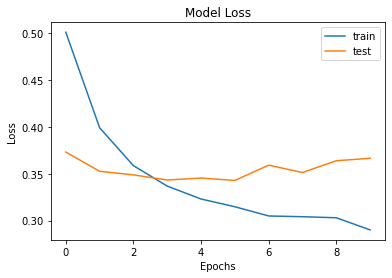

In [164]:
#Plotting the loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

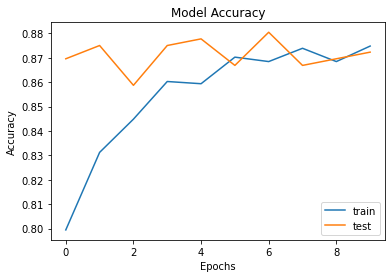

In [165]:
#Plotting the accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Text(0.5, 257.44, 'Predicted label')

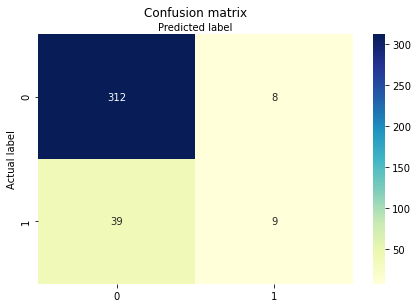

In [166]:
#Creating the confusion matrix
y_test = np.argmax(y_test, axis = 1)
cnf_matrix = confusion_matrix(y_test, classes)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [167]:
#Print a nicely formatted report
print(classification_report(y_test,classes))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       320
           1       0.53      0.19      0.28        48

    accuracy                           0.87       368
   macro avg       0.71      0.58      0.60       368
weighted avg       0.84      0.87      0.84       368



In [179]:
def predict_prob(number):
    return [number[0],1-number[0]]

y_prob = np.array(list(map(predict_prob, model.predict(X_test))))

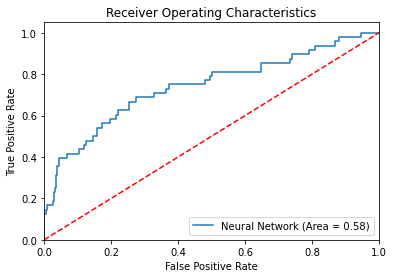

In [180]:
#Plot the ROC curve
model_roc_auc = roc_auc_score(y_test,classes)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Neural Network (Area = %0.2f)' % model_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()